# Table of Contents

## - Import libraries and define functions + Initial setup

## - Pre-process Illumina files

## - Make figures

# Import libraries and define functions + Initial setup

In [2]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
import os
import glob


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    dff = df.copy()
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = dff.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        dff["gene_id"] = dff.index
        cols = list(dff.columns)
        cols = [cols[-1]] + cols[:-1]
        dff = dff[cols]
        dff.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = dff.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    dff.columns = list_new_names
    
    return dff 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):
    
    dff = df.copy()

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = dff.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = dff.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    cpm_columns = {}

    for col in count_columns:
        rounded_col = round(dff[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        cpm_columns[cpm_name] = round(((rounded_col/(rounded_col.sum())) * 1000000), 2)

    new_data = {**dff.round(2).to_dict(orient='series'), **cpm_columns}
    dff = pd.DataFrame(new_data)

    return dff

In [6]:
"""
This function loads all salmon quant.sh files with the given filename from all subdirectories 
of the provided parent directory and returns a merged counts and a merged TPM matrix.

Parameters:
filename (str): The name of the salmon file to load
parent_directory (str): The path to the parent directory containing the folders with salmon quant.sf files.

Returns:
list: A merged counts and a merged TPM matrix.
"""
    
def load_salmon_data_and_merge(filename, parent_directory):

    dataframes = []

    # Create a path pattern to find all folders containing the TSV files
    folder_pattern = os.path.join(parent_directory, '*', filename)

    # Get a list of all TSV files matching the pattern
    tsv_files = glob.glob(folder_pattern)
    
    ## Create flag for first iteration of loop
    flag_first = True
    
    # Read each TSV file into a DataFrame and append it to the list
    for tsv_file in tsv_files:
        
        ## Create column names
        sample_name = tsv_file.split("/")[-2].split("_Aligned")[0]
        tpm_name = sample_name + "_TPM"
        counts_name = sample_name + "_counts"
        
        ## Open dataframe for counts and TPM
        df_counts = pd.read_csv(tsv_file, sep='\t', usecols=[0, 4], names=["transcript_id", counts_name],
                               low_memory=False, header=0)
        df_tpm = pd.read_csv(tsv_file, sep='\t', usecols=[0, 3], names=["transcript_id", tpm_name], 
                             low_memory=False, header=0)
                
        ## If it is not the first iteration just add to merged dataframes
        if flag_first == False:
            
            df_meged_counts = df_meged_counts.merge(df_counts, on="transcript_id", how="inner")
            df_meged_tpm = df_meged_tpm.merge(df_tpm, on="transcript_id", how="inner")
        
        ## If it is the first iteration set merged dataframe to first dataframes
        ## Set flag_first to false
        else:
            
            df_meged_counts = df_counts.copy()
            df_meged_tpm = df_tpm.copy()
            
            flag_first = False
            
        df_meged_counts.shape
           

    return df_meged_counts, df_meged_tpm

In [7]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## - Pre-process Illumina files

In [8]:
## Set parent directory and salmon quantification file name
parent_dir = "../../../data/raw/1st_rebuttal_data/CSHL_illumina_uky_aged_brain_with_our_extended_annotation_UNIQUE/salmon_alignment_mode/"
name = "quant.sf"

## Create merged dataframe with counts and tpm
df_counts_unique, df_tpm_unique = load_salmon_data_and_merge(name, parent_dir)

In [9]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

## Parse
ref = parse_df_columns(ref, is_ref=False)

## Only keep transcripts
ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

In [10]:
## Add gene_id to dataframes
df_counts_unique = df_counts_unique.merge(ref_transcripts[["gene_id", "transcript_id"]], on="transcript_id", how="inner")

## Make gene id first column
df_counts_unique = df_counts_unique[[df_counts_unique.columns[-1]] + 
                                    [col for col in df_counts_unique if col != df_counts_unique.columns[-1]]]

## Add chromosome to all dataframes
df_counts_unique = df_counts_unique.merge(ref_transcripts[["transcript_id", "chr"]], on="transcript_id", how="inner")


## Make chromosome first column
df_counts_unique = df_counts_unique[[df_counts_unique.columns[-1]] + 
                                    [col for col in df_counts_unique if col != df_counts_unique.columns[-1]]]

In [11]:
## Add average counts, median counts, and total counts

holder = {}

holder["total_counts"] = df_counts_unique[df_counts_unique.filter(regex='count').columns].sum(axis=1)

new_data = {**df_counts_unique.to_dict(orient='series'), **holder}
df_counts_unique = pd.DataFrame(new_data)

In [12]:
## Keep only new transcripts
df_counts_unique_new = df_counts_unique.loc[df_counts_unique["transcript_id"].str.startswith("Bambu")].copy()

In [13]:
## Calculate number of samples meeting a certain counts threshold

df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 0, "0"] = "≥ 0"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 1, "1"] = "≥ 1"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 10, "10"] = "≥ 10"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 25, "25"] = "≥ 25"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 50, "50"] = "≥ 50"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 100, "100"] = "≥ 100"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 250, "250"] = "≥ 250"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 500, "500"] = "≥ 500"
df_counts_unique_new.loc[df_counts_unique_new["total_counts"] >= 1000, "1000"] = "≥ 1000"

In [14]:
## Import names of high_confidence (hf) new transcripts

hf_transcripts = pd.read_csv("../../../references/high_confidence_transcripts.tsv", sep="\t")

## Create dataframes with only high_confidence transcripts
df_counts_unique_new_hf = df_counts_unique_new.merge(hf_transcripts, how="inner", on=["transcript_id", "gene_id", "chr"])

In [15]:
## Make gene name the second column
df_counts_unique_new_hf = df_counts_unique_new_hf[df_counts_unique_new_hf.columns[-1:].tolist() + 
                                                  df_counts_unique_new_hf.columns[:-1].tolist()]

In [16]:
## Log 2 + 1 transformation of columns
df_counts_unique_new_hf["log2_total_counts_plus1"] = np.log2(df_counts_unique_new_hf["total_counts"] + 1)

df_counts_unique_new["log2_total_counts_plus1"] = np.log2(df_counts_unique_new["total_counts"] + 1)

In [17]:
## Add gene names to unique_new dataframes

gene_names = pd.read_csv("../../../references/gene_names.tsv", sep="\t")

df_counts_unique_new = df_counts_unique_new.merge(gene_names, on=["gene_id", "chr"], how="left")

df_counts_unique_new['gene_name'].fillna(df_counts_unique_new['gene_id'], inplace=True)

## Make gene name first column

df_counts_unique_new = df_counts_unique_new[df_counts_unique_new.columns[-1:].tolist() + 
                                                  df_counts_unique_new.columns[:-1].tolist()]

In [18]:
## Only keep log2 + 1 for total columns

main_columns = ["gene_name", "gene_id", "transcript_id", "chr", "total_counts", 
                "log2_total_counts_plus1", "0", "1", "10", "25", "50", "100", "250", "500", "1000"]

df_counts_unique_new_hf_plots = df_counts_unique_new_hf[main_columns].copy()


df_counts_unique_new_plots = df_counts_unique_new[main_columns].copy()

## - Make plots (High-confidence)

In [19]:
## Create Type column to define type of transcript discovery

df_counts_unique_new_hf_plots.loc[df_counts_unique_new_hf_plots["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_unique_new_hf_plots.loc[~df_counts_unique_new_hf_plots["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_unique_new_hf_plots.loc[df_counts_unique_new_hf_plots["chr"] == "MT", "Type"] = "New from mito"

In [20]:
## Create melted dataframe with counts threshold
df_counts_unique_new_hf_plots_melt = df_counts_unique_new_hf_plots.melt(id_vars=["transcript_id", "Type"], 
                                                                        value_vars=["0", "1", "10", "25", "50", "100", "250", "500", "1000"],
                                                                        value_name='counts_threshold')

In [21]:
list_num_all = []
list_num_nfk = []
list_num_nfn = []
list_num_nfm = []
list_threshold = []

for i in range(0, 1001):
    
    above_hf = df_counts_unique_new_hf_plots.loc[df_counts_unique_new_hf_plots["total_counts"] >= i].copy()
    
    num_all = above_hf.shape[0]
    num_nfk = above_hf.loc[above_hf["Type"] == "New from known"].shape[0]
    num_nfn = above_hf.loc[above_hf["Type"] == "New from new"].shape[0]
    num_nfm = above_hf.loc[above_hf["Type"] == "New from mito"].shape[0]
    
    list_num_all.append(num_all)
    list_num_nfk.append(num_nfk)
    list_num_nfn.append(num_nfn)
    list_num_nfm.append(num_nfm)
    list_threshold.append(i)

In [22]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (170*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

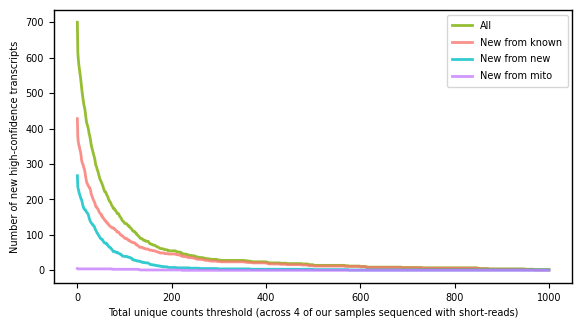

In [23]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_threshold, list_num_all, color=ggplot2_colors[2], label="All", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_nfk, color=ggplot2_colors[0], label="New from known", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_nfn, color=ggplot2_colors[4], label="New from new", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_nfm, color=ggplot2_colors[6], label="New from mito", linewidth=2, alpha=0.8)

plt.xticks(np.arange(0, 1001, 200))
plt.xlabel('Total unique counts threshold (across 4 of our samples sequenced with short-reads)')
plt.ylabel('Number of new high-confidence transcripts')
plt.legend(loc="upper right", fontsize=7, borderpad=0.6, labelspacing=0.7)

plt.savefig('../../../figures/1st_rebuttal_figures/short_read_validations/lineplot_high_confidence_threshold_across_total_counts_OURS.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [24]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (85*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

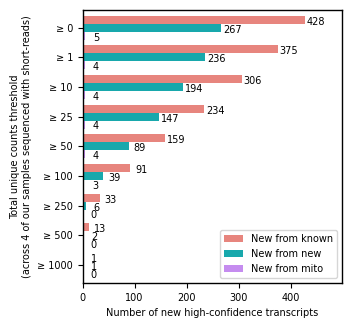

In [25]:
ax = sns.countplot(y='counts_threshold', hue='Type', data=df_counts_unique_new_hf_plots_melt, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"],
                  order=["≥ 1000", "≥ 500", "≥ 250", "≥ 100", "≥ 50", "≥ 25", "≥ 10", "≥ 1", "≥ 0"])


plt.xlim(0,499)
plt.ylim(-0.6, 8.6)

# Adding labels to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(8, -1.3), 
                textcoords='offset points',
                fontsize=7)
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

plt.ylabel("Total unique counts threshold\n(across 4 of our samples sequenced with short-reads)")
plt.xlabel("Number of new high-confidence transcripts")

plt.savefig('../../../figures/1st_rebuttal_figures/short_read_validations/barplot_high_confidence_threshold_across_total_counts_OURS.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

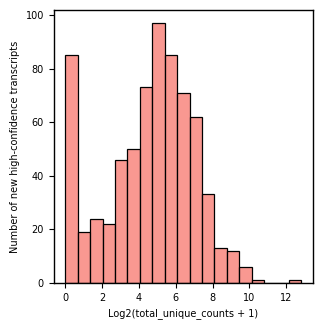

In [26]:
sns.histplot(data=df_counts_unique_new_hf_plots, x="log2_total_counts_plus1", color=ggplot2_colors[0])

plt.xlabel("Log2(total_unique_counts + 1)")
plt.ylabel("Number of new high-confidence transcripts")

plt.savefig('../../../figures/1st_rebuttal_figures/short_read_validations/histogram_high_confidence_threshold_across_total_counts_OURS.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Make plots (no filter)

In [27]:
## Create Type column to define type of transcript discovery

df_counts_unique_new_plots.loc[df_counts_unique_new_plots["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_unique_new_plots.loc[~df_counts_unique_new_plots["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_unique_new_plots.loc[df_counts_unique_new_plots["chr"] == "MT", "Type"] = "New from mito"

In [28]:
## Create melted dataframe with counts threshold
df_counts_unique_new_plots_melt = df_counts_unique_new_plots.melt(id_vars=["transcript_id", "Type"], 
                                                                        value_vars=["0", "1", "10", "25", "50", "100", "250", "500", "1000"],
                                                                        value_name='counts_threshold')

In [29]:
list_num_all = []
list_num_nfk = []
list_num_nfn = []
list_num_nfm = []
list_threshold = []

for i in range(0, 1001):
    
    above_hf = df_counts_unique_new_plots.loc[df_counts_unique_new_plots["total_counts"] >= i].copy()
    
    num_all = above_hf.shape[0]
    num_nfk = above_hf.loc[above_hf["Type"] == "New from known"].shape[0]
    num_nfn = above_hf.loc[above_hf["Type"] == "New from new"].shape[0]
    num_nfm = above_hf.loc[above_hf["Type"] == "New from mito"].shape[0]
    
    list_num_all.append(num_all)
    list_num_nfk.append(num_nfk)
    list_num_nfn.append(num_nfn)
    list_num_nfm.append(num_nfm)
    list_threshold.append(i)

In [30]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (170*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

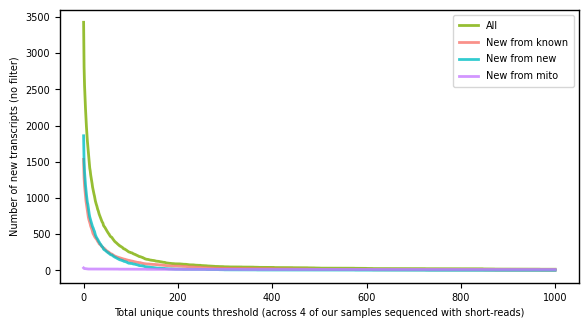

In [31]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_threshold, list_num_all, color=ggplot2_colors[2], label="All", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_nfk, color=ggplot2_colors[0], label="New from known", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_nfn, color=ggplot2_colors[4], label="New from new", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_nfm, color=ggplot2_colors[6], label="New from mito", linewidth=2, alpha=0.8)

plt.xticks(np.arange(0, 1001, 200))
plt.xlabel('Total unique counts threshold (across 4 of our samples sequenced with short-reads)')
plt.ylabel('Number of new transcripts (no filter)')
plt.legend(loc="upper right", fontsize=7, borderpad=0.6, labelspacing=0.7)

plt.savefig('../../../figures/1st_rebuttal_figures/short_read_validations/lineplot_all_new_threshold_across_total_counts_OURS.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [32]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (85*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

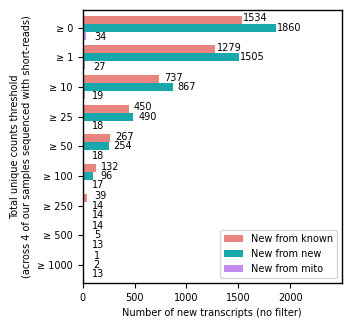

In [33]:
ax = sns.countplot(y='counts_threshold', hue='Type', data=df_counts_unique_new_plots_melt, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"],
                  order=["≥ 1000", "≥ 500", "≥ 250", "≥ 100", "≥ 50", "≥ 25", "≥ 10", "≥ 1", "≥ 0"])


plt.xlim(0,2499)
plt.ylim(-0.6, 8.6)

i = 0

# Adding labels to each bar
for p in ax.patches:
    
    if i <= 8:
        ax.annotate(f'{int(p.get_width())}', 
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                    ha='center', va='center', 
                    xytext=(10, -1), 
                    textcoords='offset points',
                    fontsize=7)
        
    elif ((i > 8) & (i <= 17)):
        
        ax.annotate(f'{int(p.get_width())}', 
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                    ha='center', va='center', 
                    xytext=(10, 0), 
                    textcoords='offset points',
                    fontsize=7)
    else:
        ax.annotate(f'{int(p.get_width())}', 
            (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
            ha='center', va='center', 
            xytext=(10, 1), 
            textcoords='offset points',
            fontsize=7)
        
        
    i = i + 1
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right")


plt.ylabel("Total unique counts threshold\n(across 4 of our samples sequenced with short-reads)")
plt.xlabel("Number of new transcripts (no filter)")

plt.savefig('../../../figures/1st_rebuttal_figures/short_read_validations/barplot_all_new_threshold_across_total_counts_OURS.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

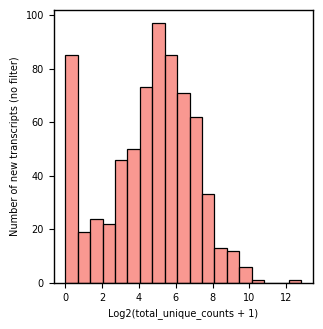

In [34]:
sns.histplot(data=df_counts_unique_new_hf_plots, x="log2_total_counts_plus1", color=ggplot2_colors[0])

plt.xlabel("Log2(total_unique_counts + 1)")
plt.ylabel("Number of new transcripts (no filter)")

plt.savefig('../../../figures/1st_rebuttal_figures/short_read_validations/histogram_all_new_threshold_across_total_counts_OURS.pdf',
            dpi=600, transparent=True, bbox_inches="tight")